In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
datasetdir = '/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/images_scaled'
os.chdir(datasetdir)

In [4]:
# Load file locations
df_info = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'classes.txt')

In [5]:
#Split the class and image name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [6]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [7]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [8]:
#Find the count of bird class in case only specific classes need to be to the model
DF_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [11]:
DF_classcounts['count'].values

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117,
       117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112,
       111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 10

## **Target Variables here: all classes with (Number of images) >= 60. Total 453 classes with 43955 images.**

In [9]:
#Selected only specific labels
target_class = DF_classcounts[(DF_classcounts['count']>=60) & (DF_classcounts['count']<=120)]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [10]:
DF_classcounts[(DF_classcounts['count']>=60) & (DF_classcounts['count']<=120)]['count'].sum()

43955

In [11]:
len(target_class)

453

In [12]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]

In [13]:
len(df_target)

43955

In [14]:
# Move 'class_id' and 'image_location' into string type features 
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [15]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)

**Split the data into train set 60%, validation set 15% and a test set 25%.**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.25, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/5, train_size=4/5, random_state=44)

print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))
print("Number of posters for training: ", len(X_test))

Number of posters for training:  26372
Number of posters for validation:  6594
Number of posters for training:  10989


In [23]:
len(X_train) + len(X_val) + len(X_test)

43955

In [24]:
len(X_train)/len(df_target)

0.5999772494596747

In [25]:
len(X_val)/len(df_target)

0.150017062905244

In [26]:
len(X_test)/len(df_target)

0.25000568763508135

In [17]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
#X_test = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_train[:5]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0831/c387c0d6fa14497aaaf1ff3443154e5a.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0613/5e26b456cdda49c1ba8d70069008d833.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0767/931ee5a595d9438fbd8571024045713e.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0914/5ec283f8edeb4abb89307c45dda2ac41.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0395/bcb091b457b944a193a5f5d5c2201c35.jpg']

In [23]:
X_train[1]

'/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0613/5e26b456cdda49c1ba8d70069008d833.jpg'

**For simplicity, let's encode our target labels into one-hot encoded labels using preprocessing.LabelBinarizer().**

In [18]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
lb.fit(y_val)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [19]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)
y_test_bin = lb.transform(y_test)

**Model ResNet50v2 preferes images with shape of (224, 224, 3).**

In [20]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

**Create a function that normalize and resize images inputs to the fixed shape required by the model.**

In [21]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    #path = '../images_scaled/'+filename
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [22]:
BATCH_SIZE = 512 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 512 # Shuffle the training data by a chunck of 512 observations

In [23]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    print(filenames)
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [24]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)
test_ds = create_dataset(X_test, y_test_bin)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0948/05b8b0c399ad4e6e8069ae6cdfdfb807.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0827/a2193fc39b5940a8aed3b545f54774a5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0750/0c052eceb9424e24baa49e73c9042f0c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0773/854313470cfc4a2e8b7e4a7045d6ed36.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0826/032a8cd95872419ab4c8d35092fbd273.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0514/826d2d7de52d49f69f8935249664772c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0786/86fadd74578744fb90eb51f240816d87.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

In [32]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 453)


In [25]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# **RESNET_v2_50**

In [26]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, trainable=False, 
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

### **Model1: no extra layers**

In [33]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
output (Dense)               (None, 453)               928197    
Total params: 24,492,997
Trainable params: 928,197
Non-trainable params: 23,564,800
_________________________________________________________________


In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history = model.fit(train_ds, epochs=40,batch_size = 128,
                            validation_data=create_dataset(X_val, y_val_bin))

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0948/05b8b0c399ad4e6e8069ae6cdfdfb807.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0827/a2193fc39b5940a8aed3b545f54774a5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0750/0c052eceb9424e24baa49e73c9042f0c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0773/854313470cfc4a2e8b7e4a7045d6ed36.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0826/032a8cd95872419ab4c8d35092fbd273.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0514/826d2d7de52d49f69f8935249664772c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0786/86fadd74578744fb90eb51f240816d87.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

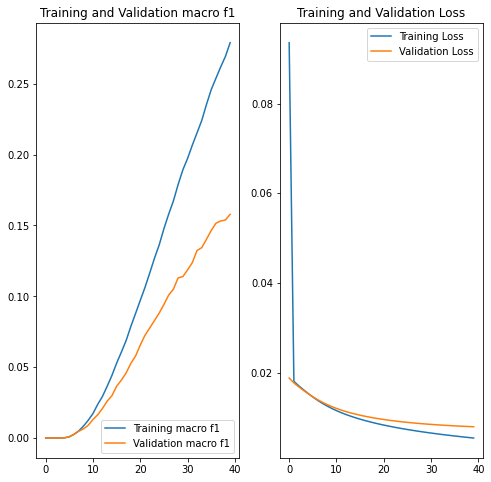

In [36]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

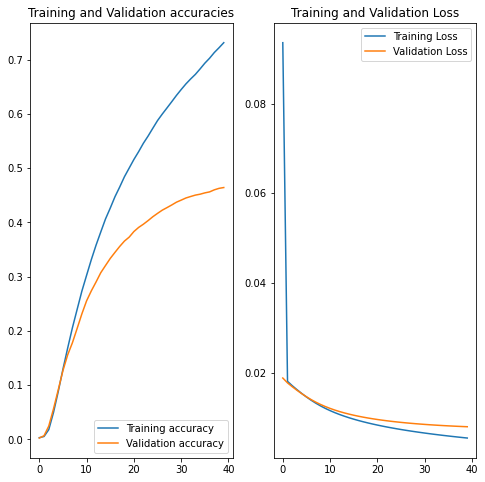

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
Result = model.evaluate(test_ds)

22/22 [==============================] - 880s 38s/step - loss: 0.0079 - macro_f1: 0.1546 - accuracy: 0.4665


## **Model2 = Model1 + Dense(1024, relu) + Dropout(0.2) + Dense(512, relu)**

In [34]:
model2 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer2'),
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
output (Dense)               (None, 453)               232389    
Total params: 26,420,165
Trainable params: 2,855,365
Non-trainable params: 23,564,800
_________________________________________________________________


In [35]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history2 = model2.fit(train_ds, epochs=60,batch_size = 128,
                            validation_data=create_dataset(X_val, y_val_bin))

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0948/05b8b0c399ad4e6e8069ae6cdfdfb807.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0827/a2193fc39b5940a8aed3b545f54774a5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0750/0c052eceb9424e24baa49e73c9042f0c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0773/854313470cfc4a2e8b7e4a7045d6ed36.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0826/032a8cd95872419ab4c8d35092fbd273.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0514/826d2d7de52d49f69f8935249664772c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0786/86fadd74578744fb90eb51f240816d87.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

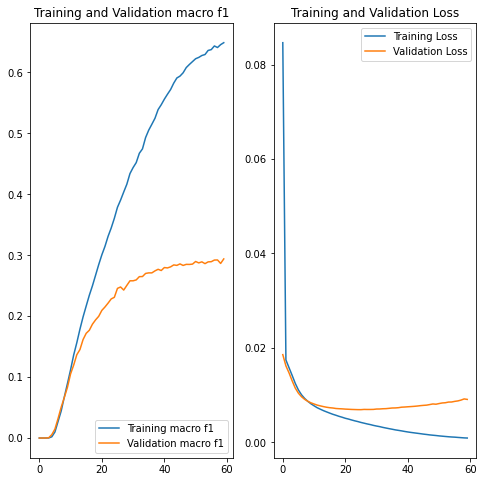

In [36]:
mf1 = history2.history['macro_f1']
val_mf1 = history2.history['val_macro_f1']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

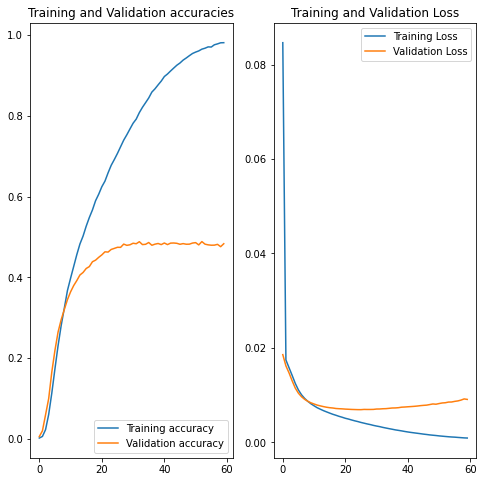

In [37]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
Result2 = model2.evaluate(test_ds)

22/22 [==============================] - 21s 912ms/step - loss: 0.0088 - macro_f1: 0.2964 - accuracy: 0.4980


## **Model3 = Model2 + More Dense Layers with Dropouts**

In [35]:
model3 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(4096, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.25),
    layers.Dense(2048, activation='relu', name='hidden_layer2'),
    layers.Dropout(0.25),
    layers.Dense(1024, activation='relu', name='hidden_layer3'),
    layers.Dropout(0.25),
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
hidden_layer1 (Dense)        (None, 4096)              8392704   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [36]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy'])
    
history3 = model3.fit(train_ds, epochs=60,batch_size = 128,
                            validation_data=create_dataset(X_val, y_val_bin))

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0948/05b8b0c399ad4e6e8069ae6cdfdfb807.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0827/a2193fc39b5940a8aed3b545f54774a5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0750/0c052eceb9424e24baa49e73c9042f0c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0773/854313470cfc4a2e8b7e4a7045d6ed36.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0826/032a8cd95872419ab4c8d35092fbd273.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0514/826d2d7de52d49f69f8935249664772c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0786/86fadd74578744fb90eb51f240816d87.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

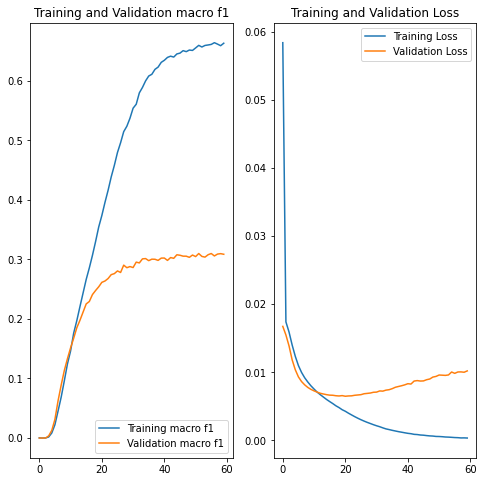

In [37]:
mf1 = history3.history['macro_f1']
val_mf1 = history3.history['val_macro_f1']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

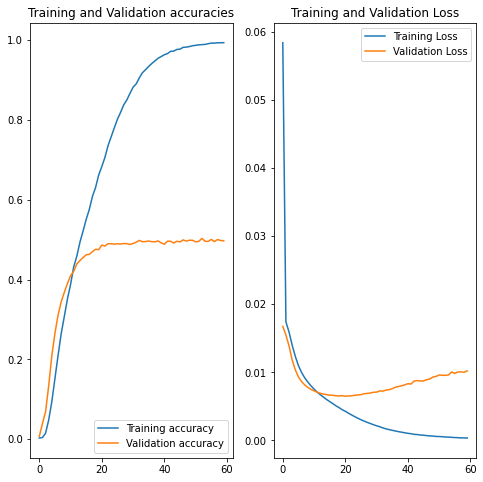

In [38]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
Result3 = model3.evaluate(test_ds)

22/22 [==============================] - 978s 43s/step - loss: 0.0100 - macro_f1: 0.3073 - accuracy: 0.5098


In [40]:
Result3

### **Model4 = Model3 with top5 accuracy classification**

In [34]:
model4 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(4096, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.25),
    layers.Dense(2048, activation='relu', name='hidden_layer2'),
    layers.Dropout(0.25),
    layers.Dense(1024, activation='relu', name='hidden_layer3'),
    layers.Dropout(0.25),
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
hidden_layer1 (Dense)        (None, 4096)              8392704   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [35]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])
    
history4 = model4.fit(train_ds, epochs=60,batch_size = 128,
                            validation_data=create_dataset(X_val, y_val_bin))


['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0948/05b8b0c399ad4e6e8069ae6cdfdfb807.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0827/a2193fc39b5940a8aed3b545f54774a5.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0750/0c052eceb9424e24baa49e73c9042f0c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0773/854313470cfc4a2e8b7e4a7045d6ed36.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0826/032a8cd95872419ab4c8d35092fbd273.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0514/826d2d7de52d49f69f8935249664772c.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0786/86fadd74578744fb90eb51f240816d87.jpg', '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/i

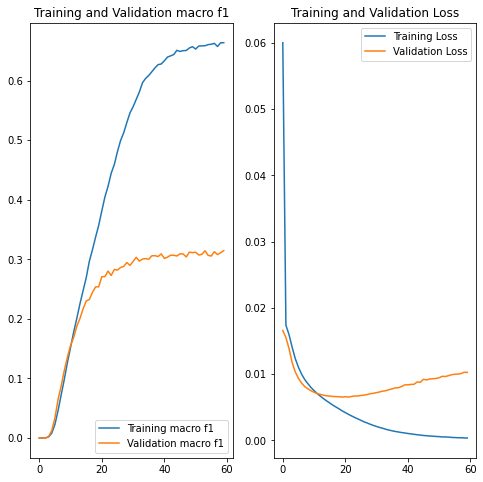

In [36]:
mf1 = history4.history['macro_f1']
val_mf1 = history4.history['val_macro_f1']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

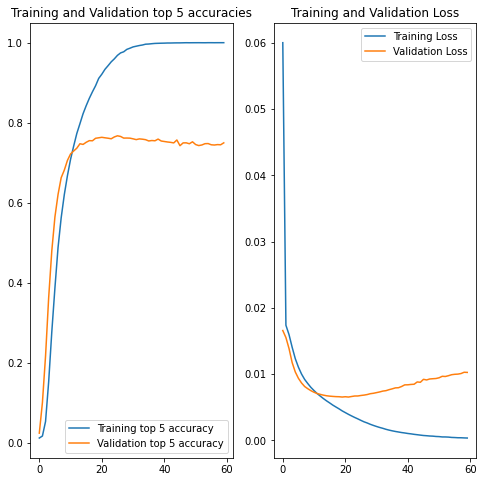

In [41]:
top5_acc = history4.history['top_k_categorical_accuracy']
val_top5_acc = history4.history['val_top_k_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, top5_acc, label='Training top 5 accuracy')
plt.plot(epochs_range, val_top5_acc, label='Validation top 5 accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation top 5 accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

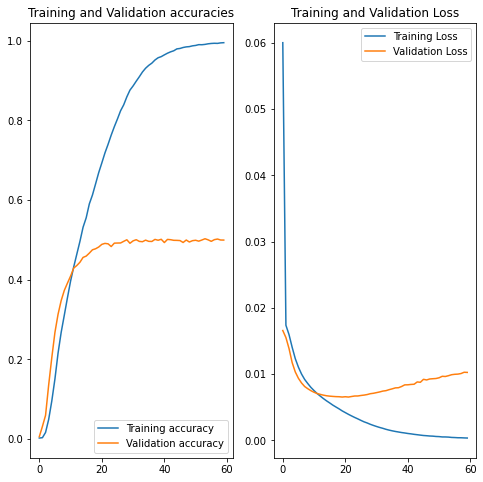

In [37]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
Result4 = model4.evaluate(test_ds)

22/22 [==============================] - 521s 22s/step - loss: 0.0101 - macro_f1: 0.3120 - accuracy: 0.5099 - top_k_categorical_accuracy: 0.7513


In [39]:
Result4

[0.01012344378978014,
 0.31200239062309265,
 0.5098735094070435,
 0.7512967586517334]

In [ ]:
# Number of correct and incorrect predictions of the model

predictions = model4.predict(test_ds)

Incorrect = (np.argmax(predictions) !=  np.argmax(y_test_bin)).sum()
Correct = (np.argmax(predictions) ==  np.argmax(y_test_bin)).sum()
print('Number of correct predictions:', Correct)
print('Number of incorrect predictions:', Incorrect)

In [42]:
# Number of correct and incorrect predictions of the model

predictions = model4.predict(test_ds)

Incorrect = (np.argmax(predictions, axis=1) !=  np.argmax(y_test_bin,axis=1)).sum()
Correct = (np.argmax(predictions, axis=1) ==  np.argmax(y_test_bin,axis=1)).sum()
print('Number of correct predictions:', Correct)
print('Number of incorrect predictions:', Incorrect)

Number of correct predictions: 25
Number of incorrect predictions: 10964


In [44]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 453)), types: (tf.float32, tf.int64)>

In [45]:
X_test

47021    0375/f7b31995629349ab8518dc7de7193671.jpg
20176    0529/6a3597a35d264169bedf725d09ad3df2.jpg
37980    0900/c7a5cecd3ae8453da056554cd172b03b.jpg
29563    0842/9b0e117340234c428e37afc3be437cc1.jpg
3959     0929/1512ee9549ba47d9b12dbc2d34e3e773.jpg
                           ...                    
47502    0971/fa473fb7cb8941a49228b5e8f66e4843.jpg
28901    0764/978aede945904ad0b234135c83e5d669.jpg
24111    0508/7ee82c788020457aaaa3896c59907bd1.jpg
5346     0636/1c66fa60a6214638beeaa4034495486d.jpg
971      0526/053a63646b01458997b6bd5e17f2ecad.jpg
Name: image_location, Length: 10989, dtype: object

In [5]:
4096*2*2*2*2

65536

In [27]:
model5 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(16384, activation='relu', name='hidden_layer3'),
    layers.Dropout(0.25),
    layers.Dense(8192, activation='relu', name='hidden_layer4'),
    layers.Dropout(0.25),
    layers.Dense(4096, activation='relu', name='hidden_layer5'),
    layers.Dropout(0.25),
    layers.Dense(2048, activation='relu', name='hidden_layer6'),
    layers.Dropout(0.25),
    layers.Dense(1024, activation='relu', name='hidden_layer7'),
    layers.Dropout(0.25),
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
hidden_layer3 (Dense)        (None, 16384)             33570816  
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
hidden_layer4 (Dense)        (None, 8192)              134225920 
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
hidden_layer5 (Dense)        (None, 4096)              33558528  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0

In [28]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])
    
history5 = model5.fit(train_ds, epochs=40,batch_size = 256,
                            validation_data=val_ds)


Epoch 1/40
52/52 [==============================] - 107s 2s/step - loss: 0.1451 - macro_f1: 1.9610e-04 - accuracy: 0.0020 - top_k_categorical_accuracy: 0.0103 - val_loss: 0.0160 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0023 - val_top_k_categorical_accuracy: 0.0112
Epoch 2/40
52/52 [==============================] - 47s 911ms/step - loss: 0.0173 - macro_f1: 0.0000e+00 - accuracy: 0.0023 - top_k_categorical_accuracy: 0.0111 - val_loss: 0.0159 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0023 - val_top_k_categorical_accuracy: 0.0144
Epoch 3/40
52/52 [==============================] - 47s 913ms/step - loss: 0.0169 - macro_f1: 0.0000e+00 - accuracy: 0.0027 - top_k_categorical_accuracy: 0.0120 - val_loss: 0.0159 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0038 - val_top_k_categorical_accuracy: 0.0146
Epoch 4/40
52/52 [==============================] - 48s 915ms/step - loss: 0.0167 - macro_f1: 0.0000e+00 - accuracy: 0.0022 - top_k_categorical_accuracy: 0.0131 - val_loss: 0.0161 - val_mac

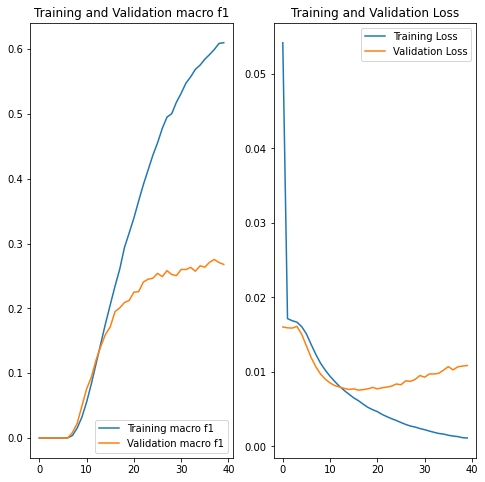

In [29]:
mf1 = history5.history['macro_f1']
val_mf1 = history5.history['val_macro_f1']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

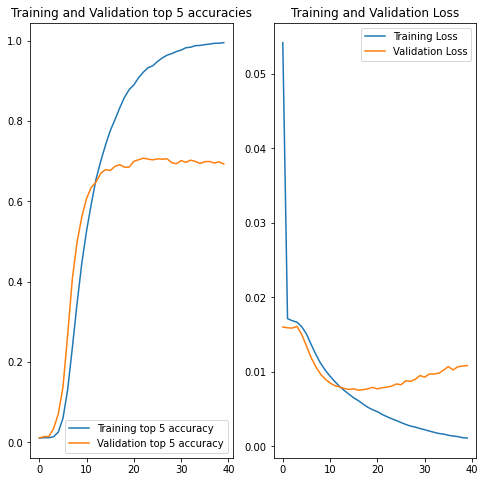

In [30]:
top5_acc = history5.history['top_k_categorical_accuracy']
val_top5_acc = history5.history['val_top_k_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, top5_acc, label='Training top 5 accuracy')
plt.plot(epochs_range, val_top5_acc, label='Validation top 5 accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation top 5 accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

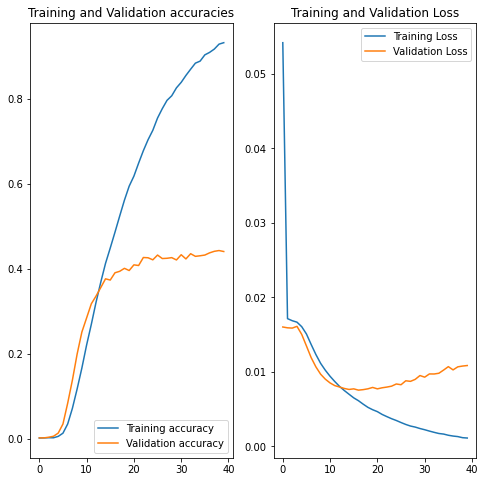

In [31]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Result5 = model5.evaluate(test_ds)

 9/22 [===========>..................] - ETA: 22s - loss: 0.0110 - macro_f1: 0.2778 - accuracy: 0.4507 - top_k_categorical_accuracy: 0.7005